### Test on 2017

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mape, mae, rmse

# fetch and prepare data exactly as before
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_53540\3831574285.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [17]:
h = len(test_ts)

# instantiate XGBoost forecaster
xgb_model = XGBModel(
    lags=52,                 # one year of weekly lags
    output_chunk_length=h,   # recursive multi-step
    n_estimators=300,
    learning_rate=0.1,       # you can tune this!
    random_state=42
)

# fit & predict
xgb_model.fit(train_ts)
xgb_forecast = xgb_model.predict(n=h)

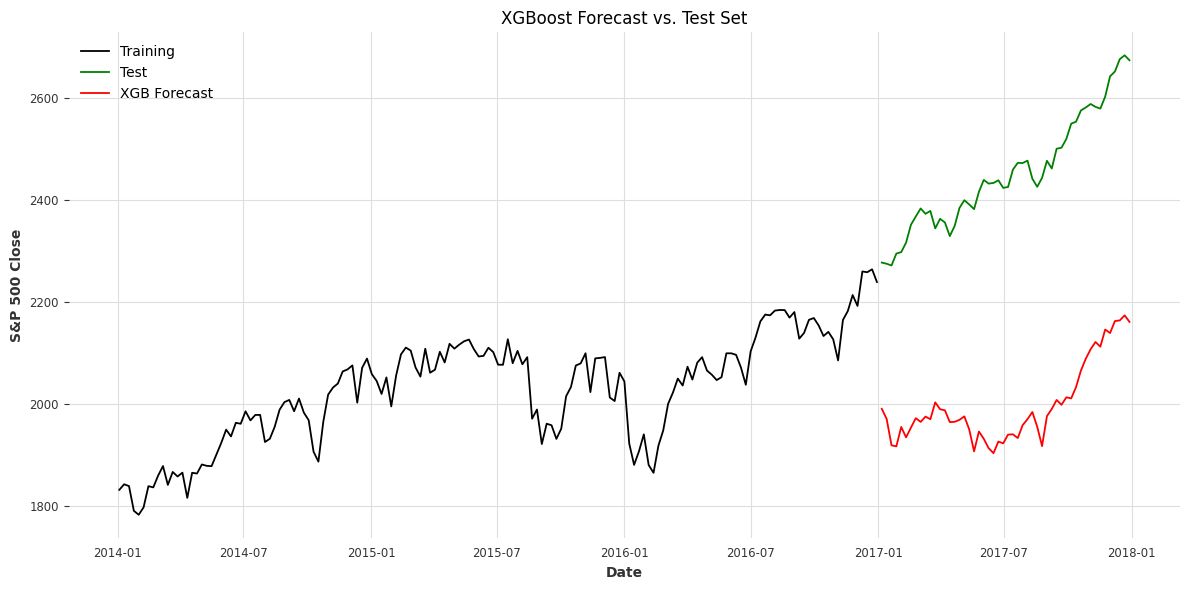

MAPE: 18.49%
MAE:  454.55
RMSE: 459.24


In [18]:
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index,    test_ts.values(),    label="Test",         color="green")
plt.plot(xgb_forecast.time_index, xgb_forecast.values(), label="XGB Forecast", color="red")
plt.title("XGBoost Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts, xgb_forecast):.2f}%")
print(f"MAE:  {mae(test_ts, xgb_forecast):.2f}")
print(f"RMSE: {rmse(test_ts, xgb_forecast):.2f}")

### Test on 2023 and 2024

In [5]:
# load data
df = sp500.history(start="2014-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_53540\3240597983.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [6]:
h = len(test_ts_2)
xgb_model.fit(train_ts_2)
xgb_forecast_2 = xgb_model.predict(n=h)

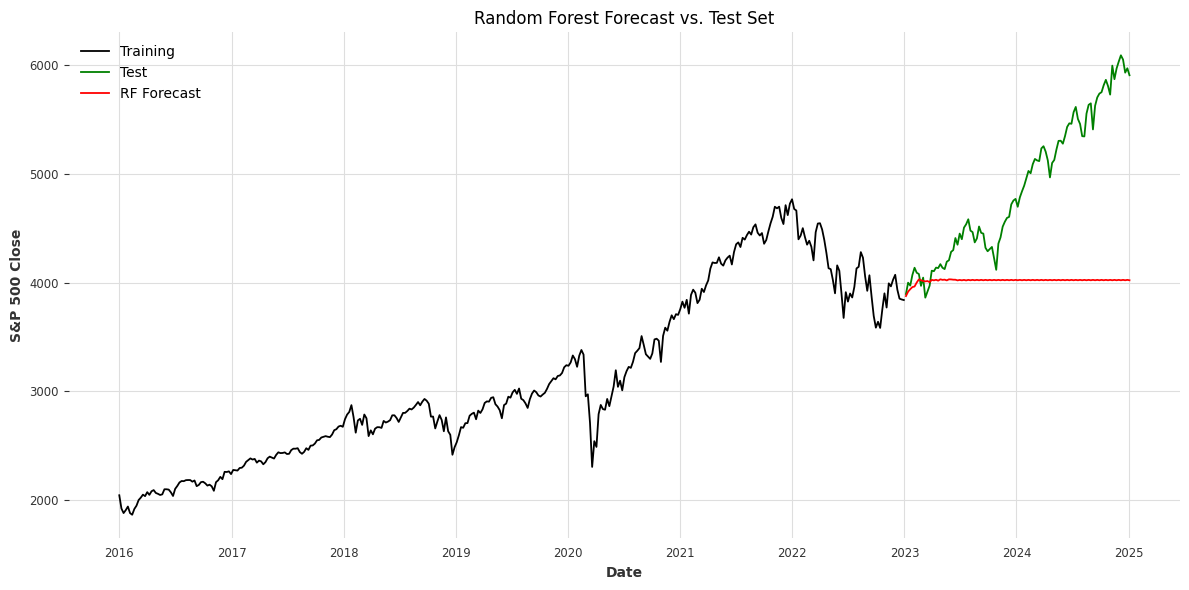

MAPE: 16.24%
MAE:  860.16
RMSE: 1070.25


In [8]:
# get only the part of train_ts from 2016-01-01 onward
train_slice_2 = train_ts_2.slice(pd.Timestamp("2016-01-01"), train_ts_2.end_time())

# plot train, test, and RF forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice_2.time_index, train_slice_2.values(), label="Training")
plt.plot(test_ts_2.time_index, test_ts_2.values(), label="Test", color="green")
plt.plot(xgb_forecast_2.time_index, xgb_forecast_2.values(), label="RF Forecast", color="red")
plt.title("Random Forest Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# compute metrics
print(f"MAPE: {mape(test_ts_2, xgb_forecast_2):.2f}%")
print(f"MAE:  {mae (test_ts_2, xgb_forecast_2):.2f}")
print(f"RMSE: {rmse(test_ts_2, xgb_forecast_2):.2f}")

### Backtesting

In [ ]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2016-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

backtest_start = pd.Timestamp("2024-01-01")
backtest_end   = pd.Timestamp("2024-12-31")
h = len(series[backtest_start:backtest_end])

C:\Users\USER\AppData\Local\Temp\ipykernel_53540\241385488.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [14]:
xgb_model.fit(series[:backtest_start])

XGBModel(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=300, learning_rate=0.1)

In [15]:
xgb_backtest = xgb_model.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,      # 1 week ahead
    stride=1,                # step forward each week
    retrain=True,            # re-fit at each step
    last_points_only=True    # keep only the direct 1-step forecast
)

actuals_bt = series[backtest_start:backtest_end]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


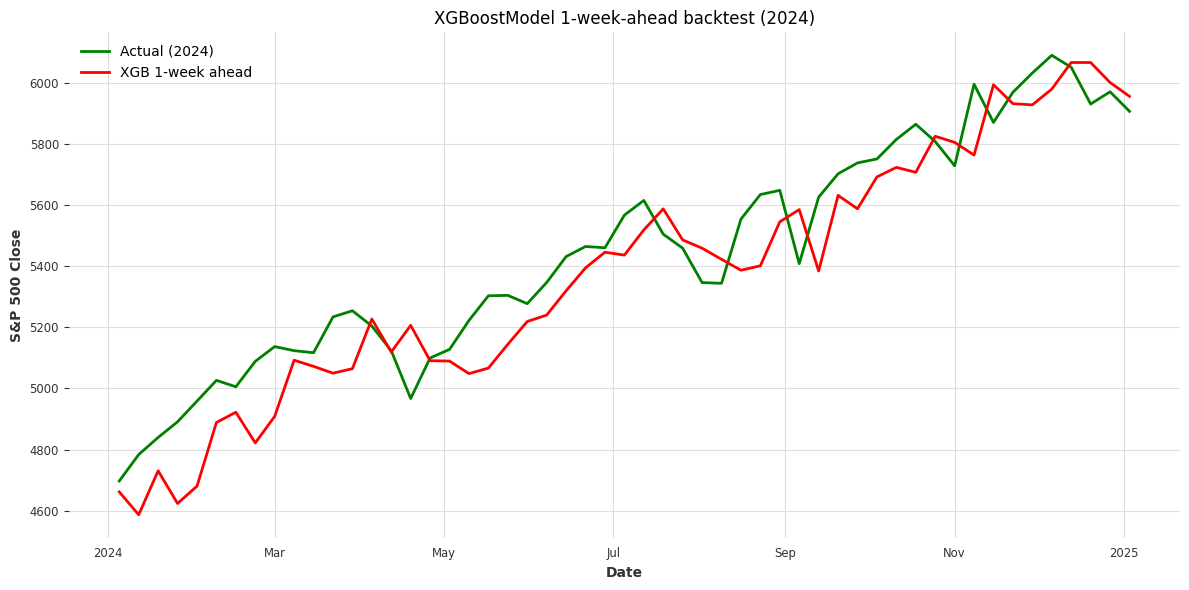

MAPE: 2.18%
MAE:  117.16
RMSE: 140.60


In [16]:
plt.figure(figsize=(12, 6))
actuals_bt.plot(label="Actual (2024)", color="green")
xgb_backtest.plot(label="XGB 1-week ahead", color="red")
plt.legend()
plt.title("XGBoostModel 1-week-ahead backtest (2024)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(actuals_bt, xgb_backtest):.2f}%")
print(f"MAE:  {mae(actuals_bt, xgb_backtest):.2f}")
print(f"RMSE: {rmse(actuals_bt, xgb_backtest):.2f}")